### importing libraries

In [1]:
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

### Reading the CSV files

In [2]:
train_df= pd.read_csv('train.csv',index_col='StudentID') 
test_df = pd.read_csv('test.csv', index_col='StudentID')

## Analyzing the data

In [3]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1530 entries, 3321 to 2747
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1530 non-null   int64  
 1   Gender             1530 non-null   int64  
 2   Ethnicity          1530 non-null   object 
 3   ParentalEducation  1388 non-null   object 
 4   StudyTimeWeekly    1530 non-null   float64
 5   Absences           1530 non-null   int64  
 6   Tutoring           1530 non-null   int64  
 7   ParentalSupport    1398 non-null   object 
 8   Extracurricular    1530 non-null   int64  
 9   Sports             1530 non-null   int64  
 10  Music              1530 non-null   int64  
 11  Volunteering       1530 non-null   int64  
 12  GPA                1530 non-null   float64
dtypes: float64(2), int64(8), object(3)
memory usage: 167.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 2340 to 1592
Data columns (total 13 columns):
 #   Co

Select the rows which have N/A values 

In [4]:
combine_df = pd.concat([train_df,
                        test_df])

combine_df[combine_df.isnull().any(axis=1)]

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA
StudentID,,,,,,,,,,,,,
2644,16,0,Other,Some College,6.845312,13,0,NaN,0,0,1,0,1.852672
2811,16,1,Caucasian,Some College,7.520836,5,0,NaN,0,0,0,0,2.631368
1687,16,0,Caucasian,Some College,0.184018,11,1,NaN,1,0,0,0,1.810409
1294,16,0,Caucasian,High School,6.682860,6,1,NaN,0,0,0,1,2.546517
2034,16,1,African American,Some College,3.153221,13,1,NaN,0,1,0,0,2.058575
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,17,0,Asian,NaN,1.915084,18,0,Moderate,0,1,0,1,1.199651
2426,16,1,Asian,NaN,14.283063,13,1,Low,0,0,0,0,1.880065
1475,17,1,African American,Some College,1.444587,24,0,NaN,0,0,0,0,0.000000


Make `ParentalEducation` and `ParentalSupport` categorical for better visualizations

In [5]:
education_order = ['High School', 'Bachelor', 'Some College', 'Higher']
combine_df['ParentalEducation'] = pd.Categorical(
    combine_df['ParentalEducation'],
    categories=education_order,
    ordered=True
)

support_order = ['Low','Moderate','High','Very High']
combine_df['ParentalSupport'] = pd.Categorical(
    combine_df['ParentalSupport'],
    categories=support_order,
    ordered=True
)

### Visualize the relationship between `Ethinicity` and `ParentalEducation`

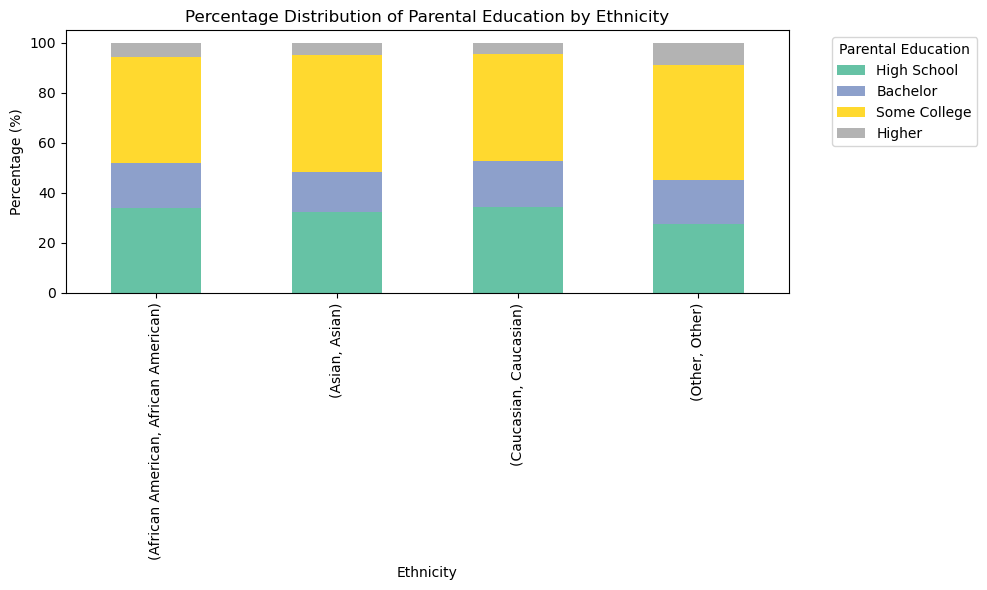

In [6]:
percentages = (
    combine_df.groupby(['Ethnicity', 'ParentalEducation'],
                       observed=True).size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Other families are more educated. But not much difference

### Visualize the relationship between `ParentalSupport` and `ParentalEducation`


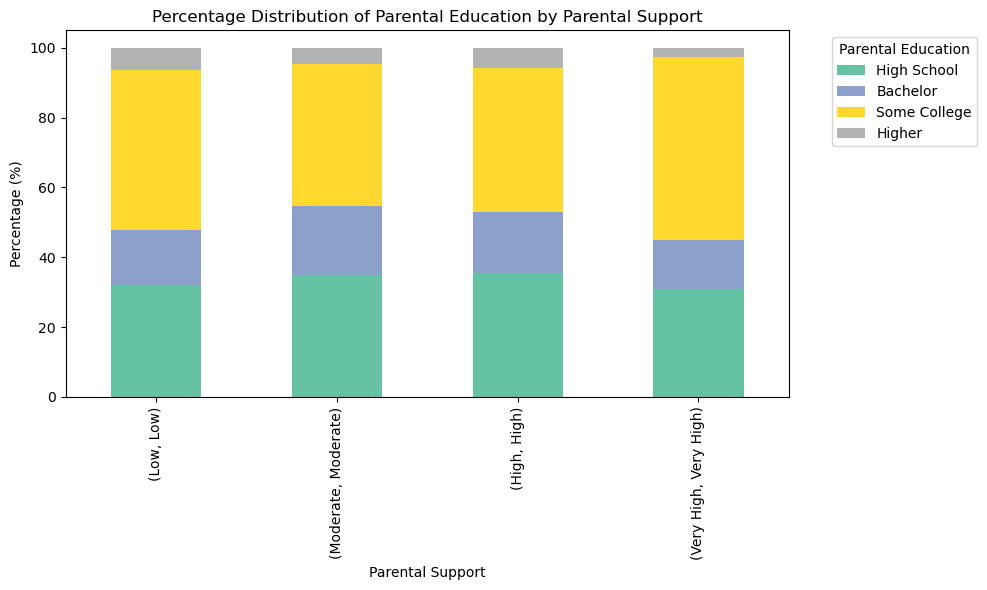

In [7]:
percentages_support = (
    combine_df.groupby(
        ['ParentalSupport', 'ParentalEducation'], observed=True).size()
    .groupby(level=0,observed=True)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages_support.plot(kind='bar', stacked=True,
                         figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Parental Support')
plt.xlabel('Parental Support')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

seem's like more educated families are more supportive.

### Visualize the relationship between `Extracurricular` and `ParentalEducation`

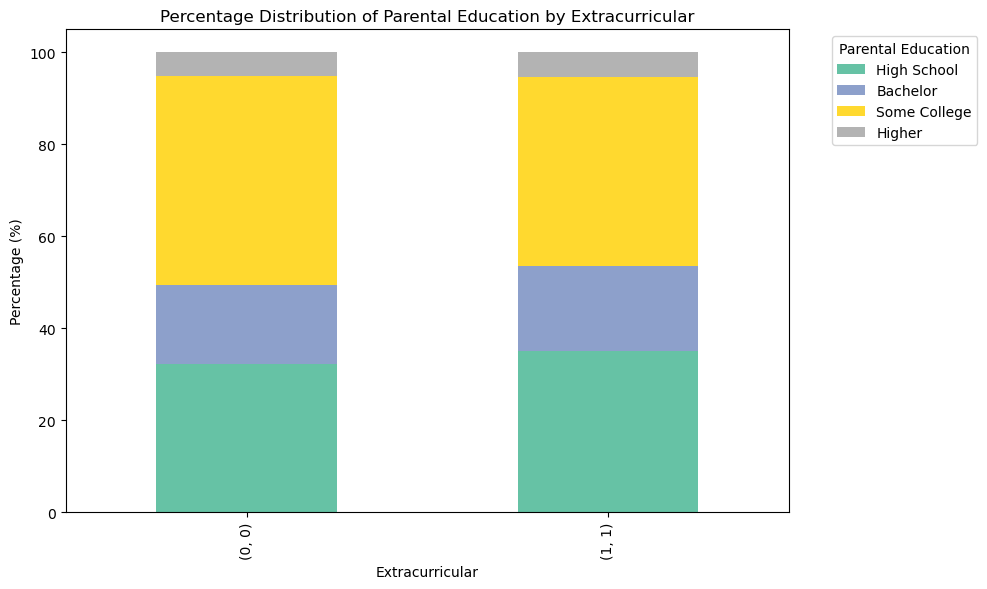

In [8]:
percentages_extra = (
    combine_df.groupby(['Extracurricular', 'ParentalEducation'],observed=True).size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages_extra.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Extracurricular')
plt.xlabel('Extracurricular')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

I can guess that more educated families are not intrested in Extracurricular. But it's not noticable.

### visualize the relationship between `Tutoring` and `ParentalEducation`

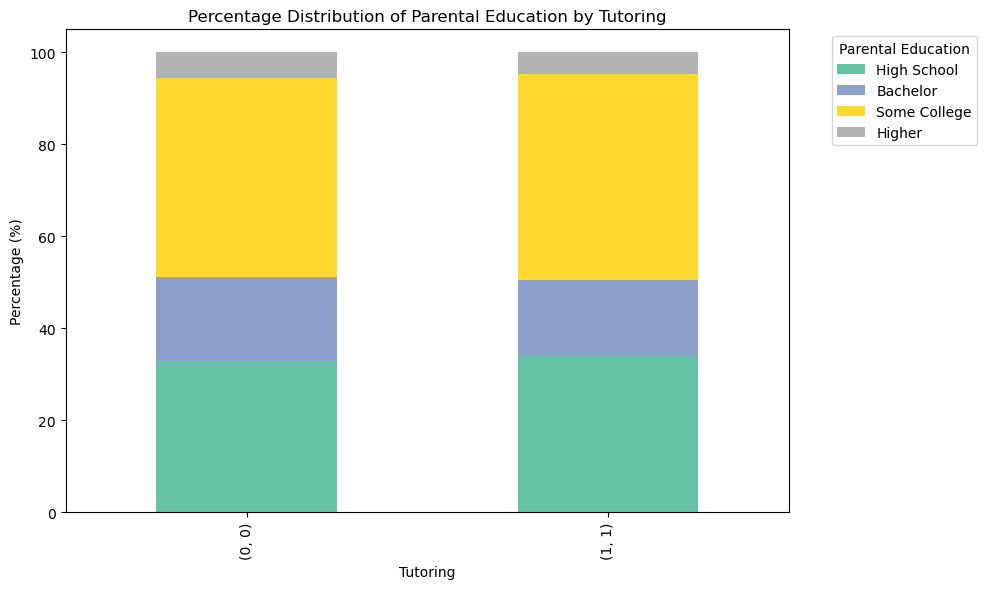

In [9]:
percentages_extra = (
    combine_df.groupby(
        ['Tutoring', 'ParentalEducation'], observed=True).size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
)

# Visualization: 100% stacked bar chart
percentages_extra.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='Set2')

plt.title('Percentage Distribution of Parental Education by Tutoring')
plt.xlabel('Tutoring')
plt.ylabel('Percentage (%)')
plt.legend(title='Parental Education',
           bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Analyze the result
It seems like the data the dataset exhibits a high degree of variability, with no clear trends or correlations between variables such as family education levels and parental support. Also there are few rows with N/A values. So I will drop them

### Drop N/A rows

In [10]:
train_df = train_df.dropna()
test_df = test_df.dropna()
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1269 entries, 3321 to 2747
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1269 non-null   int64  
 1   Gender             1269 non-null   int64  
 2   Ethnicity          1269 non-null   object 
 3   ParentalEducation  1269 non-null   object 
 4   StudyTimeWeekly    1269 non-null   float64
 5   Absences           1269 non-null   int64  
 6   Tutoring           1269 non-null   int64  
 7   ParentalSupport    1269 non-null   object 
 8   Extracurricular    1269 non-null   int64  
 9   Sports             1269 non-null   int64  
 10  Music              1269 non-null   int64  
 11  Volunteering       1269 non-null   int64  
 12  GPA                1269 non-null   float64
dtypes: float64(2), int64(8), object(3)
memory usage: 138.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 317 entries, 2340 to 1592
Data columns (total 13 columns):
 #   Co

### Convert categorical data to numerical data 

In [11]:
education_mapping = {edu: idx for idx, edu in enumerate(education_order)}
support_mapping = {sup: idx for idx, sup in enumerate(support_order)}

train_df['ParentalEducation'] = train_df['ParentalEducation'].map(education_mapping)
test_df['ParentalEducation'] = test_df['ParentalEducation'].map(education_mapping)

train_df['ParentalSupport'] = train_df['ParentalSupport'].map(support_mapping)
test_df['ParentalSupport'] = test_df['ParentalSupport'].map(support_mapping)

### One-hot encoding for `Ethnicity`

In [12]:
train_df = pd.get_dummies(train_df, columns=['Ethnicity'],prefix='Ethnicity').astype('float')
test_df = pd.get_dummies(test_df, columns=['Ethnicity'], prefix='Ethnicity').astype('float')

In [13]:
train_df

,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Other
StudentID,,,,,,,,,,,,,,,,
3321,17.0,1.0,0.0,9.906353,25.0,0.0,2.0,1.0,1.0,0.0,0.0,1.082390,0.0,0.0,1.0,0.0
1160,18.0,0.0,0.0,4.681156,20.0,0.0,2.0,0.0,0.0,0.0,1.0,1.189549,0.0,0.0,1.0,0.0
2321,18.0,0.0,0.0,19.885760,2.0,0.0,2.0,1.0,0.0,0.0,0.0,3.517237,0.0,1.0,0.0,0.0
2419,15.0,1.0,1.0,14.806261,20.0,0.0,3.0,0.0,0.0,0.0,0.0,1.582093,1.0,0.0,0.0,0.0
1266,16.0,1.0,2.0,1.502859,10.0,1.0,2.0,0.0,0.0,0.0,0.0,2.150233,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,18.0,0.0,2.0,19.088954,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.825020,0.0,0.0,0.0,1.0
2740,17.0,0.0,0.0,9.657889,16.0,0.0,1.0,1.0,1.0,0.0,0.0,1.811622,0.0,0.0,1.0,0.0
2535,17.0,0.0,2.0,16.119403,18.0,1.0,2.0,0.0,0.0,0.0,0.0,1.844059,1.0,0.0,0.0,0.0


In [14]:
test_df

,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian,Ethnicity_Other
StudentID,,,,,,,,,,,,,,,,
2340,16.0,1.0,3.0,5.044048,25.0,1.0,1.0,1.0,0.0,0.0,0.0,0.886889,0.0,0.0,0.0,1.0
2923,18.0,0.0,1.0,18.731312,12.0,0.0,1.0,1.0,0.0,0.0,0.0,2.234696,0.0,0.0,0.0,1.0
2077,16.0,0.0,2.0,0.213403,23.0,1.0,1.0,0.0,1.0,0.0,0.0,0.875367,0.0,1.0,0.0,0.0
2735,15.0,1.0,3.0,14.645811,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.648705,1.0,0.0,0.0,0.0
2245,17.0,0.0,2.0,11.436575,1.0,0.0,2.0,1.0,0.0,0.0,0.0,3.463688,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,15.0,0.0,2.0,8.991978,10.0,1.0,2.0,1.0,0.0,0.0,0.0,2.830404,0.0,0.0,1.0,0.0
1929,16.0,1.0,2.0,16.023430,4.0,1.0,1.0,1.0,1.0,0.0,0.0,3.262270,1.0,0.0,0.0,0.0
2280,18.0,1.0,2.0,2.832227,18.0,1.0,3.0,1.0,0.0,0.0,0.0,1.419523,0.0,0.0,1.0,0.0


## Normalize the data

In [15]:
# Identify all numeric columns (excluding 'Survived')
numeric_cols = train_df.select_dtypes(
    include=['float64', 'int64']).columns.difference(['Survived'])

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the train dataset
train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])

# Transform the test dataset
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1269 entries, 3321 to 2747
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         1269 non-null   float64
 1   Gender                      1269 non-null   float64
 2   ParentalEducation           1269 non-null   float64
 3   StudyTimeWeekly             1269 non-null   float64
 4   Absences                    1269 non-null   float64
 5   Tutoring                    1269 non-null   float64
 6   ParentalSupport             1269 non-null   float64
 7   Extracurricular             1269 non-null   float64
 8   Sports                      1269 non-null   float64
 9   Music                       1269 non-null   float64
 10  Volunteering                1269 non-null   float64
 11  GPA                         1269 non-null   float64
 12  Ethnicity_African American  1269 non-null   float64
 13  Ethnicity_Asian             1269 no

### Convert it train-test and `torch.float32`

In [16]:
x_train = train_df.drop('GPA', axis=1).values
y_train = train_df['GPA'].values
x_test = test_df.drop('GPA', axis=1).values
y_test = test_df['GPA'].values

In [17]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32) 
y_test = torch.tensor(y_test, dtype=torch.float32)
y_train = y_train.view(-1, 1) 
y_test = y_test.view(-1, 1)  
x_train.shape

torch.Size([1269, 15])

## Building The NN

### GPA perdictor class

In [18]:
# Define the neural network
class GPAPredictor(nn.Module):
    def __init__(self, input_size, dropout_rate=0.3):
        super(GPAPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout after activation
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)
    

### Evaluate the cost and R²

In [19]:
def evaluate_loss_r2(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            predictions.extend(outputs.numpy().flatten())
            actuals.extend(targets.numpy().flatten())

    r2 = r2_score(actuals, predictions)
    return test_loss / len(test_loader), r2

### Train function
- MSE
- Adam
- R²

In [20]:
def train_model(model, train_loader, test_loader, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    r2_scores = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        test_loss, r2 = evaluate_loss_r2(model, test_loader, criterion)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        r2_scores.append(r2)

        # print(
        #     f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, R²: {r2:.4f}")
    
    return (train_losses, test_losses, r2_scores,r2)



### Preparing datasets for training

In [ ]:
input_size = x_train.shape[1]      

# Training
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# Testing
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Hyperparameter Optimization

In [22]:
# Define hyperparameter search space
param_grid = {
    "learning_rate": [0.001, 0.0005, 0.0001],
    "batch_size": [8, 16, 32],
    "dropout_rate": [0.2, 0.3, 0.5]
}
epochs = 18
# Generate all possible combinations
param_combinations = list(itertools.product(*param_grid.values()))

# Function to perform hyperparameter search
def hyperparameter_search(train_data, test_data, input_size, epochs=epochs):
    best_r2 = -float("inf")
    best_params = None
    best_losses = None
    for params in param_combinations:
        lr, batch_size, dropout_rate = params


        # Prepare data loaders
        train_loader = torch.utils.data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(
            test_data, batch_size=batch_size, shuffle=False)

        # Create model
        model = GPAPredictor(input_size, dropout_rate)

        # Train model
        losses = train_model(model, train_loader, test_loader, epochs=epochs, lr=lr)

        # Evaluate model
        r2 = losses[3]
        
        print(
            f"Training with lr={lr}, batch_size={batch_size}, dropout={dropout_rate}, R²={r2:.4f}")
        # Track the best model
        if r2 > best_r2:
            best_r2 = r2
            best_params = params
            best_losses = losses

    print(
        f"\nBest Hyperparameters: LR={best_params[0]}, Batch={best_params[1]}, Dropout={best_params[2]}")
    print(f"Best R² Score: {best_r2:.4f}")
    return best_losses

## Train

In [23]:
losses = hyperparameter_search(train_dataset, test_dataset, input_size)

Training with lr=0.001, batch_size=8, dropout=0.2, R²=0.9439
Training with lr=0.001, batch_size=8, dropout=0.3, R²=0.9368
Training with lr=0.001, batch_size=8, dropout=0.5, R²=0.9081
Training with lr=0.001, batch_size=16, dropout=0.2, R²=0.9387
Training with lr=0.001, batch_size=16, dropout=0.3, R²=0.9366
Training with lr=0.001, batch_size=16, dropout=0.5, R²=0.9144
Training with lr=0.001, batch_size=32, dropout=0.2, R²=0.9148
Training with lr=0.001, batch_size=32, dropout=0.3, R²=0.9313
Training with lr=0.001, batch_size=32, dropout=0.5, R²=0.9097
Training with lr=0.0005, batch_size=8, dropout=0.2, R²=0.9346
Training with lr=0.0005, batch_size=8, dropout=0.3, R²=0.9366
Training with lr=0.0005, batch_size=8, dropout=0.5, R²=0.8627
Training with lr=0.0005, batch_size=16, dropout=0.2, R²=0.9349
Training with lr=0.0005, batch_size=16, dropout=0.3, R²=0.9241
Training with lr=0.0005, batch_size=16, dropout=0.5, R²=0.8702
Training with lr=0.0005, batch_size=32, dropout=0.2, R²=0.9240
Trainin

## Visualize the best train

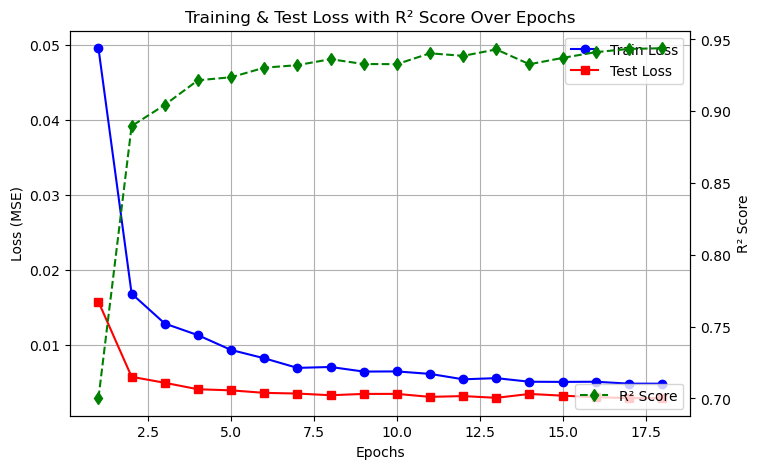

In [24]:
train_losses, test_losses, r2_scores,_ = losses
# Plot loss curves and R² score
fig, ax1 = plt.subplots(figsize=(8, 5))

# Loss plot
ax1.plot(range(1, epochs + 1), train_losses,
             label="Train Loss", marker="o", color="blue")
ax1.plot(range(1, epochs + 1), test_losses,
             label="Test Loss", marker="s", color="red")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss (MSE)")
ax1.legend(loc="upper right")
ax1.grid()

    # R² score plot
ax2 = ax1.twinx()
ax2.plot(range(1, epochs + 1), r2_scores, label="R² Score",
             marker="d", linestyle="dashed", color="green")
ax2.set_ylabel("R² Score")
ax2.legend(loc="lower right")

plt.title("Training & Test Loss with R² Score Over Epochs")
plt.show()